Cryptocurrency trading bot.

Global variable definitions.

In [1]:
traded_asset_symbols = ['STORJ', 'BTC', 'USDT']
intervals = ['1m']
raw_price = False
initial_plot = True

api_key = 'yoyoyo'
api_secret = 'yeyeye'

Installs.

In [2]:
!pip install plotly python-binance --upgrade --no-cache-dir

Requirement already up-to-date: plotly in ./anaconda3/lib/python3.7/site-packages (4.8.1)
Requirement already up-to-date: python-binance in ./anaconda3/lib/python3.7/site-packages (0.7.5)


Library imports.

In [3]:
%matplotlib inline

from binance.client import Client
from binance.enums import *
from binance.websockets import BinanceSocketManager
from binance.exceptions import BinanceAPIException
from twisted.internet import reactor
from IPython import display

import math
import random
import time
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

Function definitions.

In [4]:
class Cryptocurrency_indicator:
    def __init__(self, name, calculate, OHLC=False):
        self.name = name
        self.calculate = calculate
        self.plot = self._plot_OHLC_ if OHLC else self._plot_default_
        self.value = None

    def update(self, dataset=None, plot=False):
        if dataset is not None:
            self.dataset = dataset

        self.value = self.calculate(self.dataset.astype(float))

        if plot:
            self.plot()

    def _plot_default_(self):
        value = self.value.astype(float)

        print("\n")
        print(self.name)
        print(value)
        plt.plot(value)
        plt.show()
        print("\n")

    def _plot_OHLC_(self):
        value = self.value.astype(float)

        print("\n")
        print(self.name)
        print(self.value)
        fig = go.Figure(data=[go.Candlestick(x=value.index.to_series(), 
                                             open=value['open'], 
                                             high=value['high'], 
                                             low=value['low'], 
                                             close=value['close'])])

        fig.show()
        print("\n")


class Cryptocurrency_indicators_base:
    def __init__(self):
        self.indicators = None

    def _calculate_moving_average_(self, dataset, window=2, method='simple'):
        if method == 'simple':
            dataset = dataset.rolling(window=window)
        elif method == 'exponential':
            dataset = dataset.ewm(span=window)

        dataset = dataset.mean()
        dataset = dataset.fillna(method='backfill', axis='index')
        return dataset

    def calculate_simple_moving_average(self, dataset, window=2):
        return self._calculate_moving_average_(dataset, window=window, method='simple')

    def calculate_exponential_moving_average(self, dataset, window=2):
        return self._calculate_moving_average_(dataset, window=window, method='exponential')

    def calculate_heikin_ashi(self, df):
        df = df.tz_localize(tz=None, ambiguous='infer')
        df = df[['open', 'high', 'low', 'close']].copy().astype('float')
        heikin_ashi_df = pd.DataFrame(index=df.index.values, columns=['open', 'high', 'low', 'close'])
        heikin_ashi_df['close'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4

        for i in range(len(df)):
            if i == 0:
                heikin_ashi_df.iat[0, 0] = df['open'].iloc[0]
            else:
                heikin_ashi_df.iat[i, 0] = (heikin_ashi_df.iat[i - 1, 0] + heikin_ashi_df.iat[i - 1, 3]) / 2

        heikin_ashi_df['high'] = heikin_ashi_df.loc[:, ['open', 'close']].join(df['high']).max(axis=1)
        heikin_ashi_df['low'] = heikin_ashi_df.loc[:, ['open', 'close']].join(df['low']).min(axis=1)

        return heikin_ashi_df

    def calculate_RSI(self, ticker, span=14):
        up = ticker['close'].astype(float).pct_change()
        down = up.copy()
        up[up < 0.0] = 0.0
        down[down > 0.0] = 0.0

        up = up.ewm(span=span).mean().fillna(method='pad')
        down = down.ewm(span=span).mean().abs().fillna(method='pad')

        ticker = up / down
        ticker = 100 - (100 / (1 + ticker))

        ticker = ticker.replace([-np.inf, np.inf], np.nan)
        ticker.iloc[0] = ticker.iloc[1]
        return ticker.fillna(method='pad')

    def calculate_MACD(self, ticker, span1=12, span2=26, average='exponential'):
        shorter = self._calculate_moving_average_(ticker, window=span1, method=average)['close']
        longer = self._calculate_moving_average_(ticker, window=span2, method=average)['close']

        ticker = (shorter - longer).replace([-np.inf, np.inf], np.nan)
        ticker.iloc[0] = ticker.iloc[1]
        ticker = ticker.fillna(method='pad').to_frame(name='MACD')
        ticker['signal_line'] = ticker.MACD.ewm(span=9).mean()
        ticker['histogram'] = ticker.MACD - ticker.signal_line
        return ticker

    def calculate_ATR(self, ticker, min_periods=14):
        ticker = ticker.astype(float)
        up = pd.DataFrame([ticker['high'].shift(), 
                           ticker['close']]).fillna(method='backfill', axis='columns').max(axis='index')

        down = pd.DataFrame([ticker['low'].shift(), 
                             ticker['close']]).fillna(method='backfill', axis='columns').min(axis='index')

        ticker = (up - down).ewm(alpha=1 / min_periods, 
                                 min_periods=min_periods, 
                                 adjust=False).mean()

        ticker = ticker.replace([-np.inf, np.inf], np.nan)
        return ticker.fillna(method='backfill')

    def calculate_bollinger_bands(self, dataframe, period=20):
        df = dataframe.copy()
        df['MA'] = self._calculate_moving_average_(df, window=period, method='simple')['close']
        df['BB_up'] = df['MA'] + df['MA'].rolling(period).std()
        df['BB_down'] = df['MA'] - df['MA'].rolling(period).std()
        df['BB_width'] = df['BB_up'] - df['BB_down']
        return df[['BB_up', 'BB_down', 'BB_width']].dropna()

    def calculate_average_directional_index(self, df, n=14, n_ADX=14):
        dataset_index = df.index.copy()
        df = df.reset_index().drop(columns=['time']).astype(float)
        i = 0
        UpI = []
        DoI = []

        while i + 1 <= df.index[-1]:
            UpMove = df.loc[i + 1, 'high'] - df.loc[i, 'high']
            DoMove = df.loc[i, 'low'] - df.loc[i + 1, 'low']

            if UpMove > DoMove and UpMove > 0:
                UpD = UpMove
            else:
                UpD = 0

            UpI.append(UpD)

            if DoMove > UpMove and DoMove > 0:
                DoD = DoMove
            else:
                DoD = 0

            DoI.append(DoD)
            i += 1

        ATR = self.calculate_ATR(df, min_periods=14)
        UpI = pd.Series(UpI)
        DoI = pd.Series(DoI)
        PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean() / ATR, name='PosDI')
        NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean() / ATR, name='NegDI')
        ADX = pd.Series((abs(PosDI - NegDI) / (PosDI + NegDI)).ewm(span=n_ADX, 
                                                                   min_periods=n_ADX).mean(), 
                        name='ADX')

        df = df.join(ADX).join(PosDI).join(NegDI)
        df.index = dataset_index
        return df[['ADX', 'PosDI', 'NegDI']].dropna()

    def calculate_commodity_channel_index(self, dataset, min_periods=20):
        PP = (dataset['high'] + dataset['low'] + dataset['close']) / 3
        CCI = pd.Series((PP - PP.rolling(min_periods, min_periods=min_periods).mean()) / \
                        PP.rolling(min_periods, min_periods=min_periods).std(),
                        name='CCI')
        return dataset.join(CCI)['CCI']

    def calculate_KDJ(self, dataset):
        def get_rsv(dataset):
            low_min = dataset['low'].rolling(min_periods=1, window=9, center=False).min()
            high_max = dataset['high'].rolling(min_periods=1, window=9, center=False).max()
            return ((dataset['close'] - low_min) / (high_max - low_min)).fillna(0).astype(float) * 100

        def calc_kd(column):
            k = 50.0
            for i in (1.0 / 3.0) * column:
                k = (2.0 / 3.0) * k + i
                yield k

        dataset['K'] = list(calc_kd(get_rsv(dataset)))
        dataset['D'] = list(calc_kd(dataset['K']))
        dataset['J'] = 3 * dataset['K'] - 2 * dataset['D']
        return dataset[['K', 'D', 'J']]

    def calculate_relative_volume_level(self, 
                                        dataset, 
                                        average_1=26, 
                                        average_2=14, 
                                        method='simple'):

        volume_average = self._calculate_moving_average_(dataset, 
                                                         window=average_1, 
                                                         method=method)

        relative_volume = dataset / average_1

        smoothed_relative_volume = self._calculate_moving_average_(relative_volume, 
                                                                   window=average_2, 
                                                                   method=method)

        return smoothed_relative_volume[['volume']].pct_change()


class Cryptocurrency_triggers:
    def __init__(self):
        self.indicators = Cryptocurrency_indicators_base()

    def calculate_trend_trigger(self, dataset):
        heikin_ashi = self.indicators.calculate_simple_moving_average(dataset, window=1)
        heikin_ashi = self.indicators.calculate_heikin_ashi(heikin_ashi)
        heikin_ashi = self.indicators.calculate_exponential_moving_average(dataset, window=1)
        return (heikin_ashi['close'] - heikin_ashi['open']) > 0

    def calculate_overtraded_trigger(self, dataset):
        RSI_6 = self.indicators.calculate_RSI(dataset, span=6)
        RSI_12 = self.indicators.calculate_RSI(dataset, span=12)
        return RSI_6 > RSI_12

    def calculate_trend_strength_trigger(self, dataset):
        ADX = self.indicators.calculate_average_directional_index(dataset, n=14, n_ADX=14)
        return ADX['ADX'] > 0.25

    def calculate_trend_strength_positive_trigger(self, dataset):
        ADX = self.indicators.calculate_average_directional_index(dataset, n=14, n_ADX=14)
        return ADX['PosDI'] > ADX['NegDI']

    def calculate_trend_strength_negative_trigger(self, dataset):
        ADX = self.indicators.calculate_average_directional_index(dataset, n=14, n_ADX=14)
        return ADX['PosDI'] < ADX['NegDI']

    def calculate_momentum_trigger(self, dataset):
        KDJ = self.indicators.calculate_KDJ(dataset)
        return KDJ['J'] > KDJ['D']

    def calculate_volatility_trigger(self, dataset):
        bollinger_bands = self.indicators.calculate_bollinger_bands(dataset, period=20)
        return (bollinger_bands['BB_width'] / dataset['close']) > 0.0005

    def calculate_MACD_trigger(self, dataset):
        MACD = self.indicators.calculate_MACD(dataset)
        return MACD['histogram'] > 0

    def calculate_real_trigger(self, dataset):
        return (dataset['close'] - dataset['open']) > 0

    def calculate_relative_volume_level_trigger(self, dataset, threshold=1.75):
        relative_volume_level = self.indicators.calculate_relative_volume_level(dataset)
        return relative_volume_level > threshold


class Cryptocurrency_indicators:
    def __init__(self):
        self.indicators = Cryptocurrency_triggers()
        self.setup()

    def setup(self):
        self._setup_(self.indicators)

    def update(self, dataset, plot=False):
        self._update_(self.indicators, dataset, plot=plot)

    def _setup_(self, cls):
        next_indicators = cls.indicators

        if next_indicators is not None:
            self._setup_(next_indicators)

        indicators = [indicator for indicator in dir(cls) if indicator.startswith('calculate_')]
        calculators = [getattr(cls, indicator) for indicator in indicators]

        for indicator, calculator in zip(indicators, calculators):
            setattr(cls, 
                    indicator[10:], 
                    Cryptocurrency_indicator(name=indicator[10:], 
                                             calculate=calculator, 
                                             OHLC=False))

    def _update_(self, cls, dataset, plot=False):
        next_indicators = cls.indicators

        if next_indicators is not None:
            self._update_(next_indicators, dataset, plot=plot)

        indicators = [indicator for indicator in dir(cls)]
        calculators = [getattr(cls, indicator) for indicator in indicators]

        for calculator in calculators:
            if isinstance(calculator, Cryptocurrency_indicator):
                calculator.update(dataset, plot=plot)


class Cryptocurrency_pair_info:
    def __init__(self, client, pair):
        self.client = client
        self.pair = pair

        pair_info = client.get_symbol_info(self.pair)
        self.base_asset = pair_info['baseAsset']
        self.quote_asset = pair_info['quoteAsset']
        self.precision = pair_info['quotePrecision']

        filters = pair_info['filters']
        price_filter = [ticker for ticker in filters if ticker['filterType'] == 'PRICE_FILTER']
        lot_size = [ticker for ticker in filters if ticker['filterType'] == 'LOT_SIZE']
        self.tick_size = [ticker['tickSize'].find('1') - 2 for ticker in price_filter][0]
        self.step_size = [ticker['stepSize'].find('1') - 2 for ticker in lot_size][0]

        self.calculate_balance()

    def calculate_balance(self):
        self.base_asset_balance = float(self.client.get_asset_balance(asset=self.base_asset)['free'])
        self.quote_asset_balance = float(self.client.get_asset_balance(asset=self.quote_asset)['free'])
        self.pair_last_price = float(self.client.get_ticker(symbol=self.pair)['lastPrice'])
        self.pair_buy_balance = self.quote_asset_balance / self.pair_last_price
        self.pair_sell_balance = self.base_asset_balance * self.pair_last_price
        self.pair_combined_base_balance = self.pair_buy_balance + self.base_asset_balance
        self.pair_combined_quote_balance = self.pair_sell_balance + self.quote_asset_balance

    def print_balance(self):
        print("\n")
        print('base_asset_balance: ', self.base_asset_balance)
        print('quote_asset_balance: ', self.quote_asset_balance)
        print('pair_last_price: ', self.pair_last_price)
        print('pair_buy_balance: ', self.pair_buy_balance)
        print('pair_sell_balance: ', self.pair_sell_balance)
        print('pair_combined_base_balance: ', self.pair_combined_base_balance)
        print('pair_combined_quote_balance: ', self.pair_combined_quote_balance)
        print("\n")


class Cryptocurrency_pair_at_interval:
    def __init__(self, client, info, interval, download=True):
        self.dataset = pd.DataFrame(columns=['open', 'high', 'low', 'close', 'volume'])
        self.interval = interval
        self.period = self.get_n_periods_from_time(n=100)
        self.indicators = None

        if download:
            self.dataset = self.download_dataset(client=client, symbol=info.pair)

        if self.interval != 'price':
            self.indicators = Cryptocurrency_indicators()

    def get_n_periods_from_time(self, n=100):
        return str(int(self.interval[:-1]) * n) + self.interval[-1:]

    def download_dataset(self, client, symbol):
        if self.interval == 'price':
            return pd.DataFrame(client.get_recent_trades(symbol=symbol))
        else:
            dataset_downloaded = \
                client.get_historical_klines(symbol=symbol, 
                                             interval=self.interval, 
                                             start_str=self.period)

            dataset_downloaded = pd.DataFrame(dataset_downloaded, 
                                              columns=['time', 
                                                       'open', 
                                                       'high', 
                                                       'low', 
                                                       'close', 
                                                       'volume', 
                                                       'Close time', 
                                                       'Quote asset volume', 
                                                       'Number of trades', 
                                                       'Taker buy base asset volume', 
                                                       'Taker buy quote asset volume', 
                                                       'Ignore'])

            four_hours = 14400
            milliseconds = 1000

            dataset_downloaded['time'] = \
                dataset_downloaded['time'].apply(lambda timestamp: \
                                                 datetime.datetime.fromtimestamp((timestamp / \
                                                                                  milliseconds) - \
                                                                                 four_hours))

            dataset_downloaded = dataset_downloaded[['time', 
                                                     'open', 
                                                     'high', 
                                                     'low', 
                                                     'close', 
                                                     'volume']]

            dataset_downloaded.set_index('time', inplace=True)
            return dataset_downloaded.applymap(lambda entry: entry.rstrip('0').rstrip('.'))


class Cryptocurrency_trader:
    def __init__(self, pair):
        self.state = 'entry'
        self.is_tradable = True
        self.pair = pair
        self.info = self.pair.info

        self.calculate_position()

    def calculate_position(self):
        if self.info.pair_buy_balance > self.info.base_asset_balance:
            self.position = 'sell'
        elif self.info.base_asset_balance > self.info.pair_buy_balance:
            self.position = 'buy'

    def trade(self, percentage_to_trade=0.999999):
        if self.position == 'sell':
            coins_available = self.info.pair_buy_balance
            side = Client.SIDE_BUY
            position = 'buy'
        elif self.position == 'buy':
            coins_available = self.info.pair_sell_balance
            side = Client.SIDE_SELL
            position = 'sell'

        coins_available *= percentage_to_trade
        quantity = math.floor(coins_available * 10**self.info.step_size) / \
                        float(10**self.info.step_size)

        if self.info.tick_size < 0:
            quantity = math.floor(coins_available * abs(self.info.tick_size)) / \
                            float(abs(self.info.tick_size))

        client.create_order(symbol=self.info.pair, 
                            side=side, 
                            type=Client.ORDER_TYPE_MARKET, 
                            quantity=quantity, 
                            recvWindow=2000)

        self.pair.info.calculate_balance()
        self.pair.info.print_balance()

        if self.state == 'exit':
            self.state = 'entry'
        elif self.state == 'entry':
            self.state = 'exit'

        print("\nPosition for base asset " + self.info.base_asset + ' is ' + position + '.')
        print('Position for quote asset ' + self.info.quote_asset + ' is ' + self.position + '.')
        print('State is ' + self.state + ".\n")
        self.position = position


class Cryptocurrency_pair(Cryptocurrency_trader):
    def __init__(self, 
                 client, 
                 pair, 
                 intervals=intervals, 
                 raw_price=True, 
                 download=True):

        self.raw_price = raw_price
        self.download = download

        if self.raw_price:
            intervals = intervals + ['price']

        self.info = self.get_pair_info(client, pair)

        super().__init__(self)

        self.interval = self.get_datasets(client, intervals)

    def get_pair_info(self, client, pair):
        return Cryptocurrency_pair_info(client=client, pair=pair)

    def get_datasets(self, client, intervals):
        dataset = dict()

        for interval in intervals:
            dataset[interval] = Cryptocurrency_pair_at_interval(client=client, 
                                                                info=self.info, 
                                                                interval=interval, 
                                                                download=self.download)

        return dataset

    def make_OHLC_dataset(self, dataset, interval=intervals[0]):
        dataset = dataset.resample(interval)
        volume = dataset.agg({'quantity': ['sum']})['quantity']
        dataset = dataset.agg({'price': ['first', 'max', 'min', 'last']})['price']
        dataset['volume'] = volume
        dataset = dataset.dropna(axis='index')
        dataset = dataset.rename(columns={'first': 'open', 
                                          'max': 'high', 
                                          'min': 'low', 
                                          'last': 'close', 
                                          'sum': 'volume'})

        return dataset


class Cryptocurrency_bot:
    def __init__(self, 
                 client, 
                 traded_asset_symbols=traded_asset_symbols, 
                 intervals=intervals, 
                 raw_price=False, 
                 initial_plot=False):

        self.all_symbols = self.get_all_symbols(client)
        traded_pair_symbols = self.get_traded_pairs_from_assets(traded_asset_symbols)

        self.pairs = self.get_pairs(client, 
                                    intervals, 
                                    raw_price, 
                                    traded_pair_symbols)

        self.traded_asset_symbol = self.get_richest_asset(traded_asset_symbols, traded_pair_symbols)
        self.traded_pair_symbol = self.get_most_promising_pair()

        for pair in list(self.pairs.keys()):
            for interval in intervals:
                self.pairs[pair].interval[interval].indicators.update(
                    self.pairs[pair].interval[interval].dataset, 
                    plot=initial_plot
                )

    def get_most_promising_pair(self):
        tradable_pair_symbols = []

        for symbol in self.pairs.keys():
            if self.pairs[symbol].is_tradable is True and \
                    (self.pairs[symbol].info.base_asset == self.traded_asset_symbol or \
                     self.pairs[symbol].info.quote_asset == self.traded_asset_symbol):
                tradable_pair_symbols.append(symbol)

        return random.choice(tradable_pair_symbols)

    def get_all_symbols(self, client):
        return [symbol['symbol'] for symbol in client.get_all_tickers()]

    def get_traded_pairs_from_assets(self, traded_asset_symbols):
        traded_pair_symbols = []
        for base_asset in traded_asset_symbols:
            for quote_asset in traded_asset_symbols:
                if base_asset != quote_asset:
                    for pair in [base_asset + quote_asset, quote_asset + base_asset]:
                        if pair in self.all_symbols:
                            traded_pair_symbols.append(pair)

        return traded_pair_symbols

    def get_pairs(self, 
                  client, 
                  intervals, 
                  raw_price, 
                  traded_pair_symbols):

        pairs = dict()
        for pair in traded_pair_symbols:
            pairs[pair] = Cryptocurrency_pair(client=client, 
                                              pair=pair, 
                                              intervals=intervals, 
                                              raw_price=raw_price, 
                                              download=True)

        return pairs

    def get_richest_asset(self, traded_asset_symbols, traded_pair_symbols):
        richest_count = dict()
        for traded_asset_symbol in traded_asset_symbols:
            richest_count.update({traded_asset_symbol: 0})

        for traded_pair_symbol in traded_pair_symbols:
            base_asset = self.pairs[traded_pair_symbol].info.base_asset
            quote_asset = self.pairs[traded_pair_symbol].info.quote_asset
            if self.pairs[traded_pair_symbol].info.base_asset_balance >= \
                    self.pairs[traded_pair_symbol].info.quote_asset_balance:
                richest_count.update({base_asset: richest_count[base_asset] + 1})
            elif self.pairs[traded_pair_symbol].info.base_asset_balance < \
                    self.pairs[traded_pair_symbol].info.quote_asset_balance:
                richest_count.update({quote_asset: richest_count[quote_asset] + 1})

        return max(richest_count, key=richest_count.get)



ATR
time
2020-06-19 14:01:00    1.099024e-08
2020-06-19 14:02:00    1.099024e-08
2020-06-19 14:03:00    1.099024e-08
2020-06-19 14:04:00    1.099024e-08
2020-06-19 14:05:00    1.099024e-08
                           ...     
2020-06-19 19:36:00    1.140842e-07
2020-06-19 19:37:00    1.223639e-07
2020-06-19 19:38:00    1.179093e-07
2020-06-19 19:39:00    1.180587e-07
2020-06-19 19:40:00    1.124830e-07
Length: 340, dtype: float64


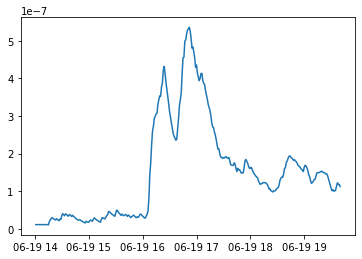





KDJ
                             K          D           J
time                                                 
2020-06-19 14:01:00  33.333333  44.444444   11.111111
2020-06-19 14:02:00  55.555556  48.148148   70.370370
2020-06-19 14:03:00  70.370370  55.555556  100.000000
2020-06-19 14:04:00  58.024691  56.378601   61.316872
2020-06-19 14:05:00  49.794239  54.183813   41.015089
...                        ...        ...         ...
2020-06-19 19:36:00  49.608726  66.968389   14.889401
2020-06-19 19:37:00  33.072484  55.669754  -12.122056
2020-06-19 19:38:00  28.188674  46.509394   -8.452767
2020-06-19 19:39:00  29.318765  40.779184    6.397926
2020-06-19 19:40:00  26.563387  36.040585    7.608991

[340 rows x 3 columns]


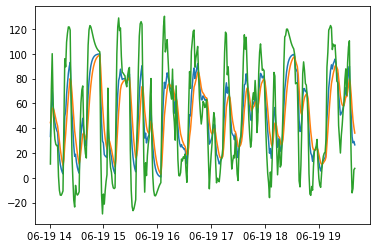





MACD
                             MACD   signal_line     histogram
time                                                         
2020-06-19 14:01:00  2.019231e-09  2.019231e-09  0.000000e+00
2020-06-19 14:02:00  2.019231e-09  2.019231e-09  0.000000e+00
2020-06-19 14:03:00  2.572901e-09  2.246145e-09  3.267561e-10
2020-06-19 14:04:00  5.953884e-10  1.686945e-09 -1.091557e-09
2020-06-19 14:05:00 -4.916967e-10  1.038849e-09 -1.530545e-09
...                           ...           ...           ...
2020-06-19 19:36:00  6.855281e-08  8.555270e-08 -1.699989e-08
2020-06-19 19:37:00  4.816166e-08  7.807449e-08 -2.991284e-08
2020-06-19 19:38:00  3.243455e-08  6.894651e-08 -3.651196e-08
2020-06-19 19:39:00  2.373172e-08  5.990355e-08 -3.617183e-08
2020-06-19 19:40:00  1.345194e-08  5.061323e-08 -3.716129e-08

[340 rows x 3 columns]


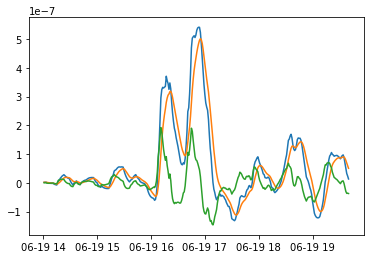





RSI
time
2020-06-19 14:01:00    100.000000
2020-06-19 14:02:00    100.000000
2020-06-19 14:03:00    100.000000
2020-06-19 14:04:00     53.097709
2020-06-19 14:05:00     53.097709
                          ...    
2020-06-19 19:36:00     33.880359
2020-06-19 19:37:00     29.245673
2020-06-19 19:38:00     31.064229
2020-06-19 19:39:00     39.962610
2020-06-19 19:40:00     35.716751
Name: close, Length: 340, dtype: float64


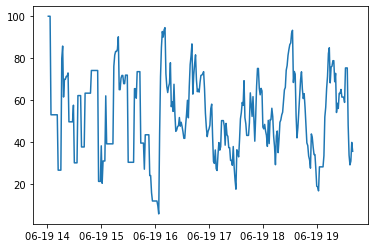





average_directional_index
                          ADX     PosDI     NegDI
time                                             
2020-06-19 14:27:00  0.269967  0.716203  0.360480
2020-06-19 14:28:00  0.317573  0.995706  0.260488
2020-06-19 14:29:00  0.291250  0.874406  0.659437
2020-06-19 14:30:00  0.269164  0.535886  0.404141
2020-06-19 14:31:00  0.250546  0.410346  0.309464
...                       ...       ...       ...
2020-06-19 19:35:00  0.294418  0.157071  0.387451
2020-06-19 19:36:00  0.315579  0.122735  0.326129
2020-06-19 19:37:00  0.345056  0.099173  0.328898
2020-06-19 19:38:00  0.370602  0.089197  0.295814
2020-06-19 19:39:00  0.398443  0.077206  0.289929

[313 rows x 3 columns]


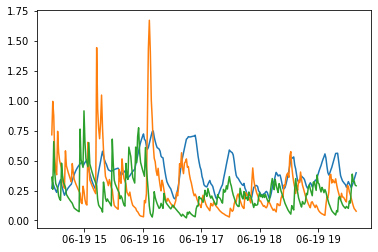





bollinger_bands
                        BB_up   BB_down      BB_width
time                                                 
2020-06-19 14:20:00  0.000019  0.000019  0.000000e+00
2020-06-19 14:21:00  0.000019  0.000019  3.801316e-09
2020-06-19 14:22:00  0.000019  0.000019  6.592659e-09
2020-06-19 14:23:00  0.000019  0.000019  9.682322e-09
2020-06-19 14:24:00  0.000019  0.000019  1.285097e-08
...                       ...       ...           ...
2020-06-19 19:36:00  0.000022  0.000021  3.045375e-07
2020-06-19 19:37:00  0.000022  0.000021  2.900587e-07
2020-06-19 19:38:00  0.000022  0.000021  2.707971e-07
2020-06-19 19:39:00  0.000022  0.000021  2.482934e-07
2020-06-19 19:40:00  0.000022  0.000021  2.242847e-07

[321 rows x 3 columns]


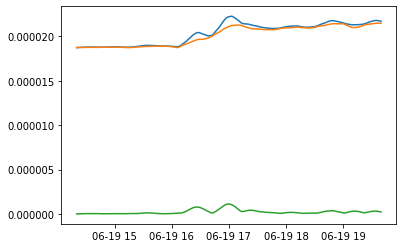





commodity_channel_index
time
2020-06-19 14:01:00         NaN
2020-06-19 14:02:00         NaN
2020-06-19 14:03:00         NaN
2020-06-19 14:04:00         NaN
2020-06-19 14:05:00         NaN
                         ...   
2020-06-19 19:36:00   -1.408620
2020-06-19 19:37:00   -2.303876
2020-06-19 19:38:00   -2.109913
2020-06-19 19:39:00   -1.309796
2020-06-19 19:40:00   -1.407941
Name: CCI, Length: 340, dtype: float64


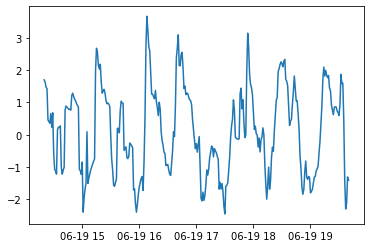





exponential_moving_average
                         open      high       low     close        volume
time                                                                     
2020-06-19 14:01:00  0.000019  0.000019  0.000019  0.000019    698.000000
2020-06-19 14:02:00  0.000019  0.000019  0.000019  0.000019    436.250000
2020-06-19 14:03:00  0.000019  0.000019  0.000019  0.000019    134.230769
2020-06-19 14:04:00  0.000019  0.000019  0.000019  0.000019   1729.100000
2020-06-19 14:05:00  0.000019  0.000019  0.000019  0.000019    575.619835
...                       ...       ...       ...       ...           ...
2020-06-19 19:36:00  0.000022  0.000022  0.000022  0.000022  22720.603555
2020-06-19 19:37:00  0.000022  0.000022  0.000021  0.000021   8410.867852
2020-06-19 19:38:00  0.000022  0.000022  0.000021  0.000021   7012.289284
2020-06-19 19:39:00  0.000022  0.000022  0.000021  0.000021   3406.763095
2020-06-19 19:40:00  0.000022  0.000022  0.000021  0.000021   1691.587698

[340 r

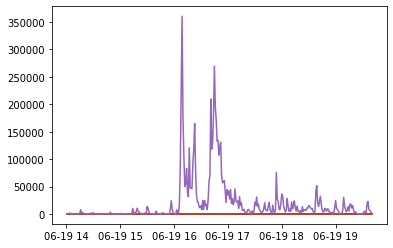





heikin_ashi
                         open      high       low     close
2020-06-19 14:01:00  0.000019  0.000019  0.000019  0.000019
2020-06-19 14:02:00  0.000019  0.000019  0.000019  0.000019
2020-06-19 14:03:00  0.000019  0.000019  0.000019  0.000019
2020-06-19 14:04:00  0.000019  0.000019  0.000019  0.000019
2020-06-19 14:05:00  0.000019  0.000019  0.000019  0.000019
...                       ...       ...       ...       ...
2020-06-19 19:36:00  0.000022  0.000022  0.000021  0.000022
2020-06-19 19:37:00  0.000022  0.000022  0.000021  0.000021
2020-06-19 19:38:00  0.000022  0.000022  0.000021  0.000021
2020-06-19 19:39:00  0.000022  0.000022  0.000022  0.000022
2020-06-19 19:40:00  0.000022  0.000022  0.000021  0.000021

[340 rows x 4 columns]


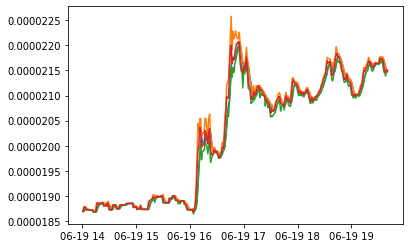





relative_volume_level
                       volume
time                         
2020-06-19 14:01:00       NaN
2020-06-19 14:02:00  0.000000
2020-06-19 14:03:00  0.000000
2020-06-19 14:04:00  0.000000
2020-06-19 14:05:00  0.000000
...                       ...
2020-06-19 19:36:00  0.419337
2020-06-19 19:37:00  0.011434
2020-06-19 19:38:00  0.091550
2020-06-19 19:39:00  0.016914
2020-06-19 19:40:00  0.010974

[340 rows x 1 columns]


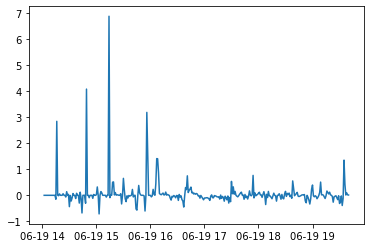





simple_moving_average
                         open      high       low     close   volume
time                                                                
2020-06-19 14:01:00  0.000019  0.000019  0.000019  0.000019    523.5
2020-06-19 14:02:00  0.000019  0.000019  0.000019  0.000019    523.5
2020-06-19 14:03:00  0.000019  0.000019  0.000019  0.000019    174.5
2020-06-19 14:04:00  0.000019  0.000019  0.000019  0.000019   1248.5
2020-06-19 14:05:00  0.000019  0.000019  0.000019  0.000019   1251.5
...                       ...       ...       ...       ...      ...
2020-06-19 19:36:00  0.000022  0.000022  0.000022  0.000022  26073.0
2020-06-19 19:37:00  0.000022  0.000022  0.000021  0.000021  12936.5
2020-06-19 19:38:00  0.000021  0.000022  0.000021  0.000021   3784.5
2020-06-19 19:39:00  0.000021  0.000022  0.000021  0.000021   3958.5
2020-06-19 19:40:00  0.000022  0.000022  0.000021  0.000021   1219.0

[340 rows x 5 columns]


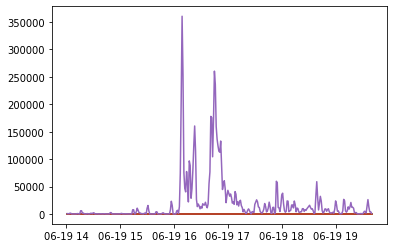





MACD_trigger
time
2020-06-19 14:01:00    0.0
2020-06-19 14:02:00    0.0
2020-06-19 14:03:00    1.0
2020-06-19 14:04:00    0.0
2020-06-19 14:05:00    0.0
                      ... 
2020-06-19 19:36:00    0.0
2020-06-19 19:37:00    0.0
2020-06-19 19:38:00    0.0
2020-06-19 19:39:00    0.0
2020-06-19 19:40:00    0.0
Name: histogram, Length: 340, dtype: float64


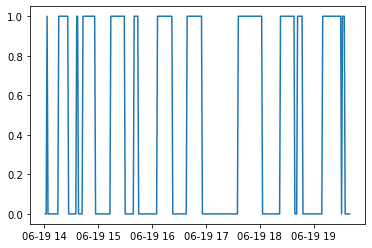





momentum_trigger
time
2020-06-19 14:01:00    0.0
2020-06-19 14:02:00    1.0
2020-06-19 14:03:00    1.0
2020-06-19 14:04:00    1.0
2020-06-19 14:05:00    0.0
                      ... 
2020-06-19 19:36:00    0.0
2020-06-19 19:37:00    0.0
2020-06-19 19:38:00    0.0
2020-06-19 19:39:00    0.0
2020-06-19 19:40:00    0.0
Length: 340, dtype: float64


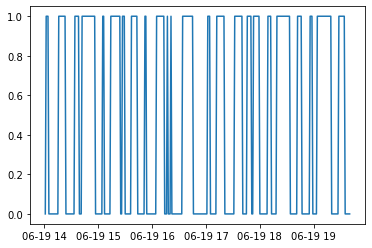





overtraded_trigger
time
2020-06-19 14:01:00    0.0
2020-06-19 14:02:00    0.0
2020-06-19 14:03:00    0.0
2020-06-19 14:04:00    0.0
2020-06-19 14:05:00    0.0
                      ... 
2020-06-19 19:36:00    0.0
2020-06-19 19:37:00    0.0
2020-06-19 19:38:00    0.0
2020-06-19 19:39:00    1.0
2020-06-19 19:40:00    0.0
Name: close, Length: 340, dtype: float64


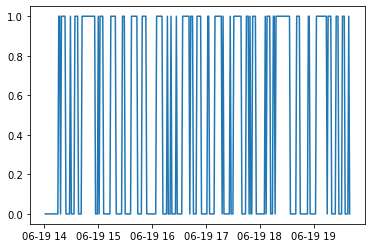





real_trigger
time
2020-06-19 14:01:00    0.0
2020-06-19 14:02:00    1.0
2020-06-19 14:03:00    0.0
2020-06-19 14:04:00    0.0
2020-06-19 14:05:00    0.0
                      ... 
2020-06-19 19:36:00    0.0
2020-06-19 19:37:00    0.0
2020-06-19 19:38:00    0.0
2020-06-19 19:39:00    1.0
2020-06-19 19:40:00    0.0
Length: 340, dtype: float64


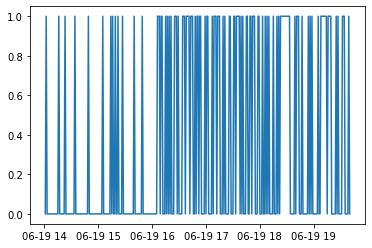





relative_volume_level_trigger
                     volume
time                       
2020-06-19 14:01:00     0.0
2020-06-19 14:02:00     0.0
2020-06-19 14:03:00     0.0
2020-06-19 14:04:00     0.0
2020-06-19 14:05:00     0.0
...                     ...
2020-06-19 19:36:00     0.0
2020-06-19 19:37:00     0.0
2020-06-19 19:38:00     0.0
2020-06-19 19:39:00     0.0
2020-06-19 19:40:00     0.0

[340 rows x 1 columns]


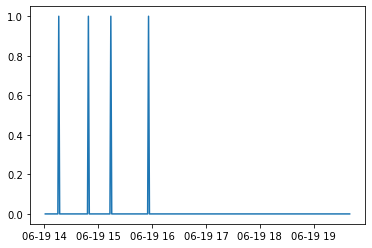





trend_strength_negative_trigger
time
2020-06-19 14:27:00    0.0
2020-06-19 14:28:00    0.0
2020-06-19 14:29:00    0.0
2020-06-19 14:30:00    0.0
2020-06-19 14:31:00    0.0
                      ... 
2020-06-19 19:35:00    1.0
2020-06-19 19:36:00    1.0
2020-06-19 19:37:00    1.0
2020-06-19 19:38:00    1.0
2020-06-19 19:39:00    1.0
Length: 313, dtype: float64


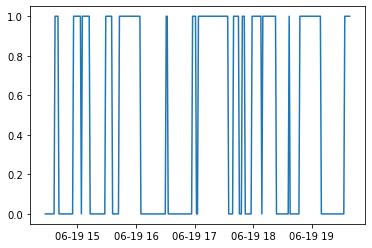





trend_strength_positive_trigger
time
2020-06-19 14:27:00    1.0
2020-06-19 14:28:00    1.0
2020-06-19 14:29:00    1.0
2020-06-19 14:30:00    1.0
2020-06-19 14:31:00    1.0
                      ... 
2020-06-19 19:35:00    0.0
2020-06-19 19:36:00    0.0
2020-06-19 19:37:00    0.0
2020-06-19 19:38:00    0.0
2020-06-19 19:39:00    0.0
Length: 313, dtype: float64


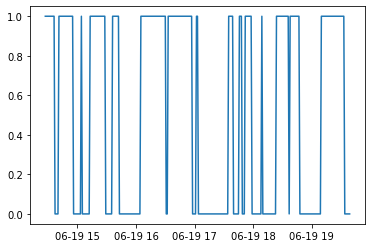





trend_strength_trigger
time
2020-06-19 14:27:00    1.0
2020-06-19 14:28:00    1.0
2020-06-19 14:29:00    1.0
2020-06-19 14:30:00    1.0
2020-06-19 14:31:00    1.0
                      ... 
2020-06-19 19:35:00    1.0
2020-06-19 19:36:00    1.0
2020-06-19 19:37:00    1.0
2020-06-19 19:38:00    1.0
2020-06-19 19:39:00    1.0
Name: ADX, Length: 313, dtype: float64


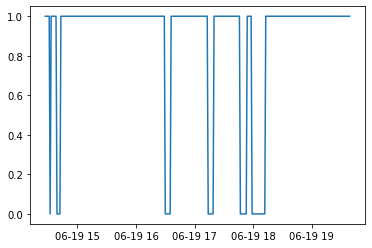





trend_trigger
time
2020-06-19 14:01:00    0.0
2020-06-19 14:02:00    1.0
2020-06-19 14:03:00    0.0
2020-06-19 14:04:00    0.0
2020-06-19 14:05:00    0.0
                      ... 
2020-06-19 19:36:00    0.0
2020-06-19 19:37:00    0.0
2020-06-19 19:38:00    0.0
2020-06-19 19:39:00    1.0
2020-06-19 19:40:00    0.0
Length: 340, dtype: float64


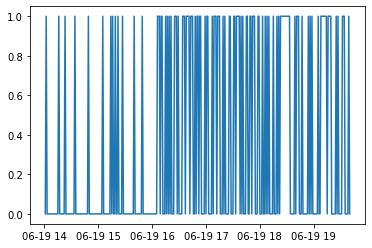





volatility_trigger
time
2020-06-19 14:01:00    0.0
2020-06-19 14:02:00    0.0
2020-06-19 14:03:00    0.0
2020-06-19 14:04:00    0.0
2020-06-19 14:05:00    0.0
                      ... 
2020-06-19 19:36:00    1.0
2020-06-19 19:37:00    1.0
2020-06-19 19:38:00    1.0
2020-06-19 19:39:00    1.0
2020-06-19 19:40:00    1.0
Length: 340, dtype: float64


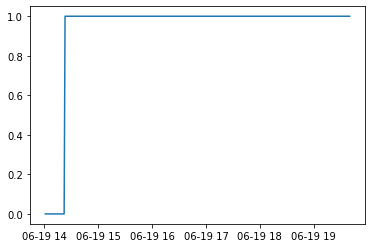





ATR
time
2020-06-19 14:01:00    7.160896
2020-06-19 14:02:00    7.160896
2020-06-19 14:03:00    7.160896
2020-06-19 14:04:00    7.160896
2020-06-19 14:05:00    7.160896
                         ...   
2020-06-19 19:36:00    5.394270
2020-06-19 19:37:00    5.397536
2020-06-19 19:38:00    5.328427
2020-06-19 19:39:00    5.231396
2020-06-19 19:40:00    5.174868
Length: 340, dtype: float64


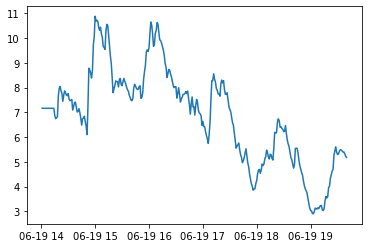





KDJ
                             K          D           J
time                                                 
2020-06-19 14:01:00  58.782051  52.927350   70.491453
2020-06-19 14:02:00  61.635759  55.830153   73.246970
2020-06-19 14:03:00  69.726188  60.462165   88.254234
2020-06-19 14:04:00  68.706348  63.210226   79.698591
2020-06-19 14:05:00  79.082009  68.500820  100.244388
...                        ...        ...         ...
2020-06-19 19:36:00  23.982896  33.236779    5.475132
2020-06-19 19:37:00  19.969862  28.814473    2.280640
2020-06-19 19:38:00  24.840694  27.489880   19.542322
2020-06-19 19:39:00  30.846177  28.608646   35.321239
2020-06-19 19:40:00  24.791171  27.336154   19.701205

[340 rows x 3 columns]


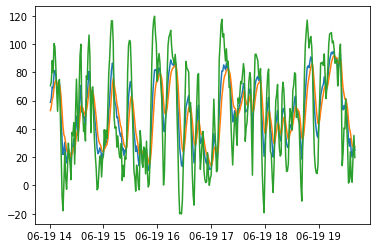





MACD
                         MACD  signal_line  histogram
time                                                 
2020-06-19 14:01:00 -0.007179    -0.007179   0.000000
2020-06-19 14:02:00 -0.007179    -0.007179   0.000000
2020-06-19 14:03:00  0.055353     0.018448   0.036904
2020-06-19 14:04:00  0.043805     0.027038   0.016767
2020-06-19 14:05:00  0.566243     0.187439   0.378804
...                       ...          ...        ...
2020-06-19 19:36:00  1.473639     2.982622  -1.508983
2020-06-19 19:37:00  1.021641     2.590426  -1.568784
2020-06-19 19:38:00  0.887208     2.249782  -1.362574
2020-06-19 19:39:00  0.856331     1.971092  -1.114761
2020-06-19 19:40:00  0.468193     1.670512  -1.202320

[340 rows x 3 columns]


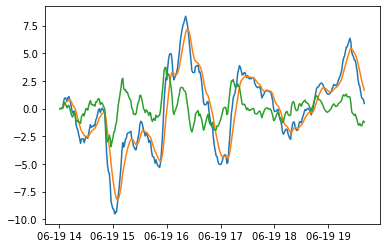





RSI
time
2020-06-19 14:01:00     0.000000
2020-06-19 14:02:00     0.000000
2020-06-19 14:03:00    88.235650
2020-06-19 14:04:00    57.911873
2020-06-19 14:05:00    92.906369
                         ...    
2020-06-19 19:36:00    39.885016
2020-06-19 19:37:00    39.637151
2020-06-19 19:38:00    47.961327
2020-06-19 19:39:00    50.820725
2020-06-19 19:40:00    40.157458
Name: close, Length: 340, dtype: float64


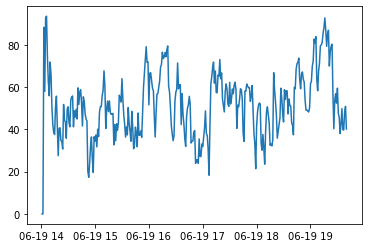





average_directional_index
                          ADX     PosDI     NegDI
time                                             
2020-06-19 14:27:00  0.323559  0.124494  0.272625
2020-06-19 14:28:00  0.306760  0.154976  0.238511
2020-06-19 14:29:00  0.292745  0.134437  0.206902
2020-06-19 14:30:00  0.290566  0.114989  0.203468
2020-06-19 14:31:00  0.298889  0.102499  0.212027
...                       ...       ...       ...
2020-06-19 19:35:00  0.401245  0.087939  0.219017
2020-06-19 19:36:00  0.411126  0.076882  0.216195
2020-06-19 19:37:00  0.377922  0.135017  0.187255
2020-06-19 19:38:00  0.335864  0.145057  0.164393
2020-06-19 19:39:00  0.320541  0.128047  0.200678

[313 rows x 3 columns]


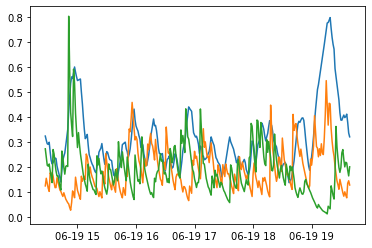





bollinger_bands
                           BB_up      BB_down  BB_width
time                                                   
2020-06-19 14:20:00  9341.406000  9341.406000  0.000000
2020-06-19 14:21:00  9341.294588  9341.230412  0.064175
2020-06-19 14:22:00  9341.023038  9340.794962  0.228076
2020-06-19 14:23:00  9340.666654  9340.186346  0.480307
2020-06-19 14:24:00  9340.266606  9339.457394  0.809212
...                          ...          ...       ...
2020-06-19 19:36:00  9347.441990  9338.228010  9.213979
2020-06-19 19:37:00  9346.812567  9338.328433  8.484133
2020-06-19 19:38:00  9346.347745  9338.664255  7.683489
2020-06-19 19:39:00  9345.720086  9338.865914  6.854172
2020-06-19 19:40:00  9344.764498  9338.758502  6.005996

[321 rows x 3 columns]


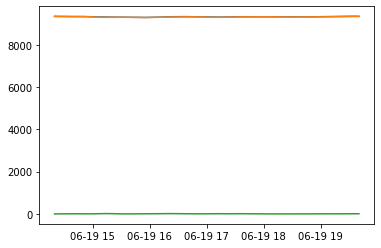





commodity_channel_index
time
2020-06-19 14:01:00         NaN
2020-06-19 14:02:00         NaN
2020-06-19 14:03:00         NaN
2020-06-19 14:04:00         NaN
2020-06-19 14:05:00         NaN
                         ...   
2020-06-19 19:36:00   -1.563091
2020-06-19 19:37:00   -1.859019
2020-06-19 19:38:00   -1.129602
2020-06-19 19:39:00   -0.745166
2020-06-19 19:40:00   -1.221395
Name: CCI, Length: 340, dtype: float64


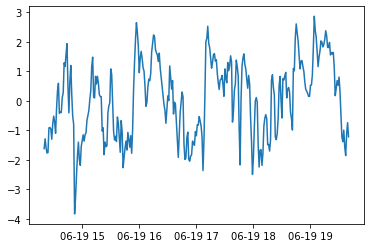





exponential_moving_average
                            open         high          low        close  \
time                                                                      
2020-06-19 14:01:00  9332.000000  9337.200000  9332.000000  9335.970000   
2020-06-19 14:02:00  9334.640000  9337.365000  9334.640000  9335.730000   
2020-06-19 14:03:00  9335.339231  9338.268462  9335.152308  9337.114615   
2020-06-19 14:04:00  9336.926000  9338.755500  9335.987750  9336.807750   
2020-06-19 14:05:00  9336.982231  9346.282810  9336.672066  9345.618843   
...                          ...          ...          ...          ...   
2020-06-19 19:36:00  9340.067671  9341.052686  9336.142981  9337.591702   
2020-06-19 19:37:00  9337.562557  9337.890895  9335.147660  9336.650567   
2020-06-19 19:38:00  9336.640852  9338.683632  9335.829220  9338.270189   
2020-06-19 19:39:00  9338.273617  9339.654544  9337.149740  9339.516730   
2020-06-19 19:40:00  9338.757872  9339.651515  9336.136580  9336.9722

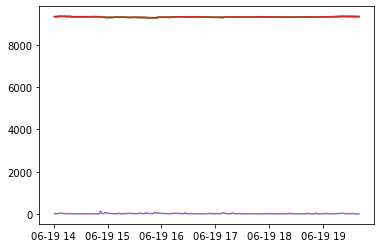





heikin_ashi
                            open         high          low      close
2020-06-19 14:01:00  9332.000000  9337.200000  9332.000000  9334.2925
2020-06-19 14:02:00  9333.146250  9337.420000  9333.146250  9336.0275
2020-06-19 14:03:00  9334.586875  9338.670000  9334.586875  9336.8575
2020-06-19 14:04:00  9335.722187  9338.990000  9335.722187  9337.4325
2020-06-19 14:05:00  9336.577344  9350.000000  9336.577344  9343.4975
...                          ...          ...          ...        ...
2020-06-19 19:36:00  9339.283824  9341.090000  9335.650000  9338.5325
2020-06-19 19:37:00  9338.908162  9338.908162  9334.650000  9335.8625
2020-06-19 19:38:00  9337.385331  9339.080000  9336.170000  9337.6275
2020-06-19 19:39:00  9337.506415  9340.140000  9337.506415  9339.2950
2020-06-19 19:40:00  9338.400708  9339.650000  9335.630000  9337.4950

[340 rows x 4 columns]


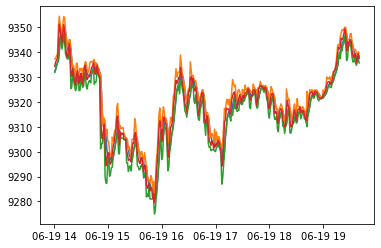





relative_volume_level
                       volume
time                         
2020-06-19 14:01:00       NaN
2020-06-19 14:02:00  0.000000
2020-06-19 14:03:00  0.000000
2020-06-19 14:04:00  0.000000
2020-06-19 14:05:00  0.000000
...                       ...
2020-06-19 19:36:00 -0.117077
2020-06-19 19:37:00 -0.060834
2020-06-19 19:38:00 -0.008040
2020-06-19 19:39:00 -0.091357
2020-06-19 19:40:00 -0.090699

[340 rows x 1 columns]


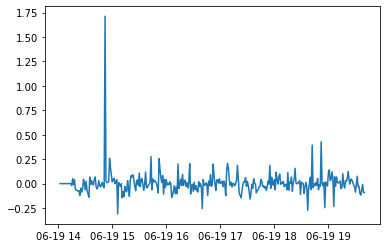





simple_moving_average
                         open      high       low     close     volume
time                                                                  
2020-06-19 14:01:00  9333.760  9337.310  9333.760  9335.810  10.512145
2020-06-19 14:02:00  9333.760  9337.310  9333.760  9335.810  10.512145
2020-06-19 14:03:00  9335.585  9338.045  9335.450  9336.690   9.167660
2020-06-19 14:04:00  9336.670  9338.830  9335.885  9337.195   9.908771
2020-06-19 14:05:00  9337.350  9344.495  9336.700  9343.315  26.041481
...                       ...       ...       ...       ...        ...
2020-06-19 19:36:00  9339.600  9341.090  9336.550  9338.695   5.819128
2020-06-19 19:37:00  9338.695  9338.700  9335.150  9336.245  10.376462
2020-06-19 19:38:00  9336.245  9337.695  9335.410  9337.630  10.217950
2020-06-19 19:39:00  9337.635  9339.610  9336.990  9339.610   4.703765
2020-06-19 19:40:00  9339.045  9339.895  9336.720  9337.920   4.343533

[340 rows x 5 columns]


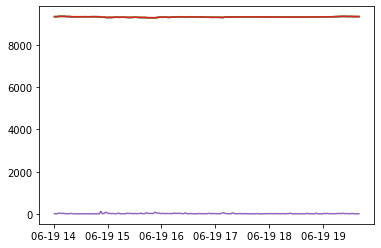





MACD_trigger
time
2020-06-19 14:01:00    0.0
2020-06-19 14:02:00    0.0
2020-06-19 14:03:00    1.0
2020-06-19 14:04:00    1.0
2020-06-19 14:05:00    1.0
                      ... 
2020-06-19 19:36:00    0.0
2020-06-19 19:37:00    0.0
2020-06-19 19:38:00    0.0
2020-06-19 19:39:00    0.0
2020-06-19 19:40:00    0.0
Name: histogram, Length: 340, dtype: float64


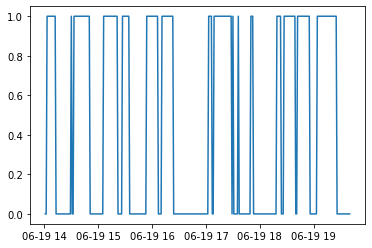





momentum_trigger
time
2020-06-19 14:01:00    1.0
2020-06-19 14:02:00    1.0
2020-06-19 14:03:00    1.0
2020-06-19 14:04:00    1.0
2020-06-19 14:05:00    1.0
                      ... 
2020-06-19 19:36:00    0.0
2020-06-19 19:37:00    0.0
2020-06-19 19:38:00    0.0
2020-06-19 19:39:00    1.0
2020-06-19 19:40:00    0.0
Length: 340, dtype: float64


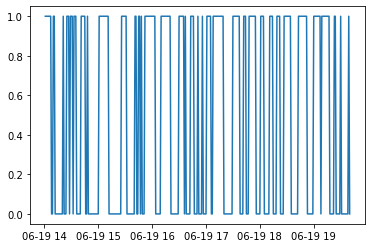





overtraded_trigger
time
2020-06-19 14:01:00    0.0
2020-06-19 14:02:00    0.0
2020-06-19 14:03:00    1.0
2020-06-19 14:04:00    0.0
2020-06-19 14:05:00    1.0
                      ... 
2020-06-19 19:36:00    0.0
2020-06-19 19:37:00    0.0
2020-06-19 19:38:00    1.0
2020-06-19 19:39:00    1.0
2020-06-19 19:40:00    0.0
Name: close, Length: 340, dtype: float64


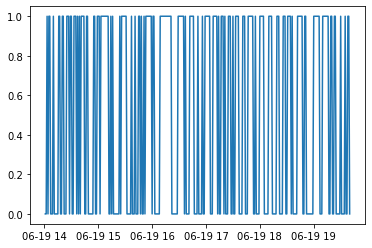





real_trigger
time
2020-06-19 14:01:00    1.0
2020-06-19 14:02:00    1.0
2020-06-19 14:03:00    1.0
2020-06-19 14:04:00    0.0
2020-06-19 14:05:00    1.0
                      ... 
2020-06-19 19:36:00    0.0
2020-06-19 19:37:00    0.0
2020-06-19 19:38:00    1.0
2020-06-19 19:39:00    1.0
2020-06-19 19:40:00    0.0
Length: 340, dtype: float64


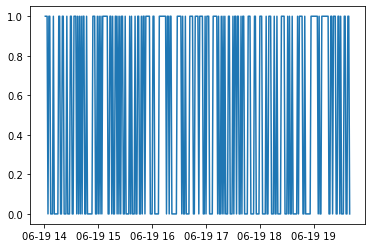





relative_volume_level_trigger
                     volume
time                       
2020-06-19 14:01:00     0.0
2020-06-19 14:02:00     0.0
2020-06-19 14:03:00     0.0
2020-06-19 14:04:00     0.0
2020-06-19 14:05:00     0.0
...                     ...
2020-06-19 19:36:00     0.0
2020-06-19 19:37:00     0.0
2020-06-19 19:38:00     0.0
2020-06-19 19:39:00     0.0
2020-06-19 19:40:00     0.0

[340 rows x 1 columns]


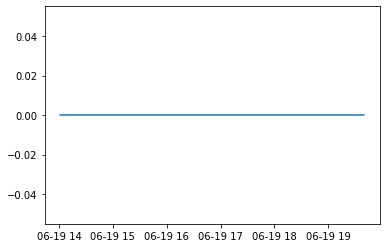





trend_strength_negative_trigger
time
2020-06-19 14:27:00    1.0
2020-06-19 14:28:00    1.0
2020-06-19 14:29:00    1.0
2020-06-19 14:30:00    1.0
2020-06-19 14:31:00    1.0
                      ... 
2020-06-19 19:35:00    1.0
2020-06-19 19:36:00    1.0
2020-06-19 19:37:00    1.0
2020-06-19 19:38:00    1.0
2020-06-19 19:39:00    1.0
Length: 313, dtype: float64


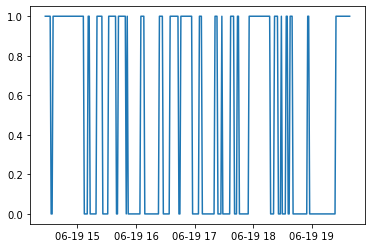





trend_strength_positive_trigger
time
2020-06-19 14:27:00    0.0
2020-06-19 14:28:00    0.0
2020-06-19 14:29:00    0.0
2020-06-19 14:30:00    0.0
2020-06-19 14:31:00    0.0
                      ... 
2020-06-19 19:35:00    0.0
2020-06-19 19:36:00    0.0
2020-06-19 19:37:00    0.0
2020-06-19 19:38:00    0.0
2020-06-19 19:39:00    0.0
Length: 313, dtype: float64


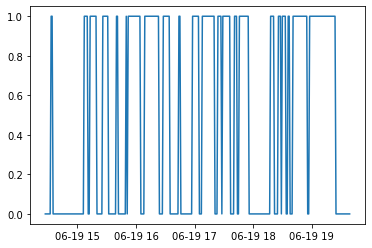





trend_strength_trigger
time
2020-06-19 14:27:00    1.0
2020-06-19 14:28:00    1.0
2020-06-19 14:29:00    1.0
2020-06-19 14:30:00    1.0
2020-06-19 14:31:00    1.0
                      ... 
2020-06-19 19:35:00    1.0
2020-06-19 19:36:00    1.0
2020-06-19 19:37:00    1.0
2020-06-19 19:38:00    1.0
2020-06-19 19:39:00    1.0
Name: ADX, Length: 313, dtype: float64


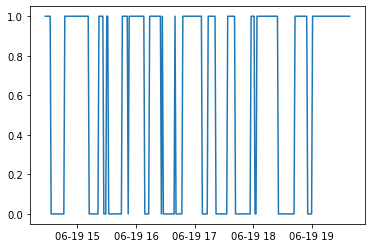





trend_trigger
time
2020-06-19 14:01:00    1.0
2020-06-19 14:02:00    1.0
2020-06-19 14:03:00    1.0
2020-06-19 14:04:00    0.0
2020-06-19 14:05:00    1.0
                      ... 
2020-06-19 19:36:00    0.0
2020-06-19 19:37:00    0.0
2020-06-19 19:38:00    1.0
2020-06-19 19:39:00    1.0
2020-06-19 19:40:00    0.0
Length: 340, dtype: float64


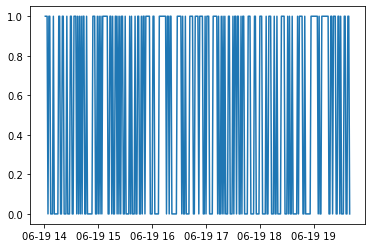





volatility_trigger
time
2020-06-19 14:01:00    0.0
2020-06-19 14:02:00    0.0
2020-06-19 14:03:00    0.0
2020-06-19 14:04:00    0.0
2020-06-19 14:05:00    0.0
                      ... 
2020-06-19 19:36:00    1.0
2020-06-19 19:37:00    1.0
2020-06-19 19:38:00    1.0
2020-06-19 19:39:00    1.0
2020-06-19 19:40:00    1.0
Length: 340, dtype: float64


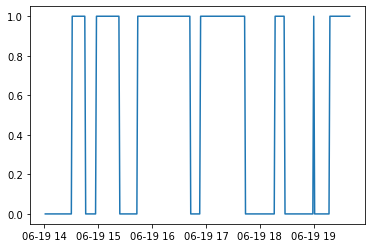

In [5]:
client = Client(api_key, api_secret)

crypto_bot = Cryptocurrency_bot(client=client, 
                                traded_asset_symbols=traded_asset_symbols, 
                                intervals=intervals, 
                                raw_price=raw_price, 
                                initial_plot=initial_plot)

In [6]:
def process_message(msg):
    global crypto_bot
    four_hours = 14400
    milliseconds = 1000
    percentage_to_trade = 0.9999

    msg = msg['data']['k']
    symbol = msg['s']
    interval = msg['i']
    pair = crypto_bot.pairs[symbol]
    pair_at_interval = pair.interval[interval]
    dataset = pair_at_interval.dataset
    precision = pair.info.precision
    if symbol in crypto_bot.pairs.keys():
        last_data = \
            pd.DataFrame([["{:0.0{}f}".format(float(msg['o']), precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['h']), precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['l']), precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['c']), precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['v']), precision).rstrip('0').rstrip('.')]], 
                         index=[datetime.datetime.fromtimestamp(int(msg['t'] / milliseconds) - four_hours)], 
                         columns=['open', 'high', 'low', 'close', 'volume'])

        last_data.index.name = 'time'

        if dataset.index[-1] == last_data.index[-1]:
            dataset = dataset.iloc[:-1].append(last_data).iloc[-1000:]
        else:
            dataset = dataset.append(last_data).iloc[-1000:]

        pair_at_interval.dataset = dataset
        pair_at_interval.indicators.update(dataset, plot=False)
        pair.info.calculate_balance()
        pair.info.print_balance()

        if symbol == crypto_bot.traded_pair_symbol:
            volatility_trigger = pair_at_interval.indicators.indicators.volatility_trigger.value.iloc[-1]
            MACD_trigger = pair_at_interval.indicators.indicators.MACD_trigger.value.iloc[-1]
            real_trigger = pair_at_interval.indicators.indicators.real_trigger.value.iloc[-1]
            momentum_trigger = pair_at_interval.indicators.indicators.momentum_trigger.value.iloc[-1]

            if pair.state == 'exit':

                if pair.position == 'sell' and \
                        volatility_trigger and \
                        MACD_trigger and \
                        real_trigger and \
                        momentum_trigger:

                    pair.trade(percentage_to_trade=percentage_to_trade)

                elif pair.position == 'buy' and \
                        volatility_trigger and \
                        not MACD_trigger and \
                        not real_trigger and \
                        not momentum_trigger:

                    pair.trade(percentage_to_trade=percentage_to_trade)

            elif pair.state == 'entry':

                if pair.position == 'sell' and \
                        volatility_trigger and \
                        MACD_trigger and \
                        real_trigger and \
                        momentum_trigger:

                    pair.trade(percentage_to_trade=percentage_to_trade)

                elif pair.position == 'buy' and \
                        volatility_trigger and \
                        not MACD_trigger and \
                        not real_trigger and \
                        not momentum_trigger:

                    pair.trade(percentage_to_trade=percentage_to_trade)

bm = BinanceSocketManager(client, user_timeout=43200)

sockets = []

for interval in intervals:
    for symbol in crypto_bot.pairs.keys():
        sockets.append(symbol.lower() + '@kline_' + interval)

conn_key = bm.start_multiplex_socket(sockets, process_message)

bm.start()

'''
scores = {}
for crypto_pair in symbols.values():
    scores.update({crypto_pair.base_asset: 0})
    scores.update({crypto_pair.quote_asset: 0})

while True:
    time.sleep(15)
    for symbol in symbols.keys():
        symbols[symbol].calculate_balance()
        symbols[symbol].calculate_position()

    scores = {}
    for crypto_pair in symbols.values():
        scores.update({crypto_pair.base_asset: 0})
        scores.update({crypto_pair.quote_asset: 0})

    for asset in scores.keys():
        for symbol in symbols.keys():
            if symbols[symbol].base_asset == asset:
                if symbols[symbol].real_trigger.iloc[-1] and \
                        symbols[symbol].real_trigger_10m.iloc[-1]:
                    scores.update({asset: scores[asset] + 1})
                else:
                    scores.update({asset: scores[asset] - 1})
            elif symbols[symbol].quote_asset == asset:
                if symbols[symbol].real_trigger.iloc[-1] and \
                        symbols[symbol].real_trigger_10m.iloc[-1]:
                    scores.update({asset: scores[asset] - 1})
                else:
                    scores.update({asset: scores[asset] + 1})

    assets = scores.keys()
    best_assets = [asset for asset in scores.keys() if scores[asset] > 0]
    print('best_assets: ', best_assets)

    if best_assets != [] and \
            not (symbols[traded_symbol].base_asset in best_assets or \
            symbols[traded_symbol].quote_asset in best_assets):

        if symbols[traded_symbol].position == 'buy':
            asset = symbols[traded_symbol].base_asset
        elif symbols[traded_symbol].position == 'sell':
            asset = symbols[traded_symbol].quote_asset

        target_symbols = [symbol for symbol in symbols.keys() \
                          if asset in symbol and any([asset in symbol for asset in best_assets])]

        target_symbol = target_symbols[0]
        symbols[target_symbol].state = 'exit'

        if symbols[target_symbol].base_asset == asset:
            symbols[target_symbol].position = 'buy'
        elif symbols[target_symbol].quote_asset == asset:
            symbols[target_symbol].position = 'sell'

        traded_symbol = target_symbol
'''

"\nscores = {}\nfor crypto_pair in symbols.values():\n    scores.update({crypto_pair.base_asset: 0})\n    scores.update({crypto_pair.quote_asset: 0})\n\nwhile True:\n    time.sleep(15)\n    for symbol in symbols.keys():\n        symbols[symbol].calculate_balance()\n        symbols[symbol].calculate_position()\n\n    scores = {}\n    for crypto_pair in symbols.values():\n        scores.update({crypto_pair.base_asset: 0})\n        scores.update({crypto_pair.quote_asset: 0})\n\n    for asset in scores.keys():\n        for symbol in symbols.keys():\n            if symbols[symbol].base_asset == asset:\n                if symbols[symbol].real_trigger.iloc[-1] and                         symbols[symbol].real_trigger_10m.iloc[-1]:\n                    scores.update({asset: scores[asset] + 1})\n                else:\n                    scores.update({asset: scores[asset] - 1})\n            elif symbols[symbol].quote_asset == asset:\n                if symbols[symbol].real_trigger.iloc[-1] and 

In [7]:
# --- Development separation --- #

In [8]:
'''
def process_message(msg):
    global symbols, traded_symbol
    four_hours = 14400
    milliseconds = 1000

    msg = msg['data']['k']
    symbol = msg['s']
    dataset = symbols[symbol].dataset
    quote_asset_precision = symbols[symbol].quote_asset_precision
    if symbol in symbols.keys():
        last_data = \
            pd.DataFrame([["{:0.0{}f}".format(float(msg['o']), quote_asset_precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['h']), quote_asset_precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['l']), quote_asset_precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['c']), quote_asset_precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['v']), quote_asset_precision).rstrip('0').rstrip('.')]], 
                         index=[datetime.datetime.fromtimestamp(int(msg['t'] / milliseconds) - four_hours)], 
                         columns=['open', 'high', 'low', 'close', 'volume'])

        last_data.index.name = 'time'

        if dataset.index[-1] == last_data.index[-1]:
            dataset = dataset.iloc[:-1].append(last_data).iloc[-1000:]
        else:
            dataset = dataset.append(last_data).iloc[-1000:]

        symbols[symbol].dataset = dataset
        symbols[symbol].calculate_indicators()

        if symbol == traded_symbol:
            if symbols[symbol].state == 'exit':

                if symbols[symbol].position == 'sell' and \
                        symbols[symbol].volatility_trigger.iloc[-1] and \
                        symbols[symbol].MACD_trigger.iloc[-1] and \
                        symbols[symbol].real_trigger.iloc[-1] and \
                        symbols[symbol].momentum_trigger.iloc[-1]:

                    symbols[symbol].trade()

                elif symbols[symbol].position == 'buy' and \
                        symbols[symbol].volatility_trigger.iloc[-1] and \
                        not symbols[symbol].MACD_trigger.iloc[-1] and \
                        not symbols[symbol].real_trigger.iloc[-1] and \
                        not symbols[symbol].momentum_trigger.iloc[-1]:

                    symbols[symbol].trade()

            elif symbols[symbol].state == 'entry':

                if symbols[symbol].position == 'sell' and \
                        symbols[symbol].volatility_trigger.iloc[-1] and \
                        symbols[symbol].MACD_trigger.iloc[-1] and \
                        symbols[symbol].real_trigger.iloc[-1] and \
                        symbols[symbol].momentum_trigger.iloc[-1]:

                    symbols[symbol].trade()

                elif symbols[symbol].position == 'buy' and \
                        symbols[symbol].volatility_trigger.iloc[-1] and \
                        not symbols[symbol].MACD_trigger.iloc[-1] and \
                        not symbols[symbol].real_trigger.iloc[-1] and \
                        not symbols[symbol].momentum_trigger.iloc[-1]:

                    symbols[symbol].trade()

bm = BinanceSocketManager(client, user_timeout=43200)
conn_key = bm.start_multiplex_socket([symbol.lower() + '@kline_' + interval for symbol in symbols.keys()], 
                                     process_message)
bm.start()
'''

'\ndef process_message(msg):\n    global symbols, traded_symbol\n    four_hours = 14400\n    milliseconds = 1000\n\n    msg = msg[\'data\'][\'k\']\n    symbol = msg[\'s\']\n    dataset = symbols[symbol].dataset\n    quote_asset_precision = symbols[symbol].quote_asset_precision\n    if symbol in symbols.keys():\n        last_data =             pd.DataFrame([["{:0.0{}f}".format(float(msg[\'o\']), quote_asset_precision).rstrip(\'0\').rstrip(\'.\'), \n                           "{:0.0{}f}".format(float(msg[\'h\']), quote_asset_precision).rstrip(\'0\').rstrip(\'.\'), \n                           "{:0.0{}f}".format(float(msg[\'l\']), quote_asset_precision).rstrip(\'0\').rstrip(\'.\'), \n                           "{:0.0{}f}".format(float(msg[\'c\']), quote_asset_precision).rstrip(\'0\').rstrip(\'.\'), \n                           "{:0.0{}f}".format(float(msg[\'v\']), quote_asset_precision).rstrip(\'0\').rstrip(\'.\')]], \n                         index=[datetime.datetime.fromtimestamp(int(ms

In [9]:
#bm.stop_socket(conn_key)
#bm.close()
#reactor.stop()



base_asset_balance:  9.2e-06
quote_asset_balance:  0.0
pair_last_price:  9336.93
pair_buy_balance:  0.0
pair_sell_balance:  0.08589975600000001
pair_combined_base_balance:  9.2e-06
pair_combined_quote_balance:  0.08589975600000001




base_asset_balance:  9.2e-06
quote_asset_balance:  0.0
pair_last_price:  9335.76
pair_buy_balance:  0.0
pair_sell_balance:  0.085888992
pair_combined_base_balance:  9.2e-06
pair_combined_quote_balance:  0.085888992




base_asset_balance:  9.2e-06
quote_asset_balance:  0.0
pair_last_price:  9336.58
pair_buy_balance:  0.0
pair_sell_balance:  0.085896536
pair_combined_base_balance:  9.2e-06
pair_combined_quote_balance:  0.085896536




base_asset_balance:  159.0
quote_asset_balance:  9.2e-06
pair_last_price:  2.147e-05
pair_buy_balance:  0.42850489054494645
pair_sell_balance:  0.00341373
pair_combined_base_balance:  159.42850489054496
pair_combined_quote_balance:  0.00342293




Unhandled Error
Traceback (most recent call last):
  File "/home/samuel/anaconda3/lib/python3.7/site-packages/twisted/python/log.py", line 103, in callWithLogger
    return callWithContext({"system": lp}, func, *args, **kw)
  File "/home/samuel/anaconda3/lib/python3.7/site-packages/twisted/python/log.py", line 86, in callWithContext
    return context.call({ILogContext: newCtx}, func, *args, **kw)
  File "/home/samuel/anaconda3/lib/python3.7/site-packages/twisted/python/context.py", line 122, in callWithContext
    return self.currentContext().callWithContext(ctx, func, *args, **kw)
  File "/home/samuel/anaconda3/lib/python3.7/site-packages/twisted/python/context.py", line 85, in callWithContext
    return func(*args,**kw)
--- <exception caught here> ---
  File "/home/samuel/anaconda3/lib/python3.7/site-packages/twisted/internet/posixbase.py", line 614, in _doReadOrWrite
    why = selectable.doRead()
  File "/home/samuel/anaconda3/lib/python3.7/site-packages/twisted/internet/tcp.py", l



base_asset_balance:  9.2e-06
quote_asset_balance:  0.0
pair_last_price:  9336.74
pair_buy_balance:  0.0
pair_sell_balance:  0.085898008
pair_combined_base_balance:  9.2e-06
pair_combined_quote_balance:  0.085898008




base_asset_balance:  159.0
quote_asset_balance:  9.2e-06
pair_last_price:  2.147e-05
pair_buy_balance:  0.42850489054494645
pair_sell_balance:  0.00341373
pair_combined_base_balance:  159.42850489054496
pair_combined_quote_balance:  0.00342293




Unhandled Error
Traceback (most recent call last):
  File "/home/samuel/anaconda3/lib/python3.7/site-packages/twisted/python/log.py", line 103, in callWithLogger
    return callWithContext({"system": lp}, func, *args, **kw)
  File "/home/samuel/anaconda3/lib/python3.7/site-packages/twisted/python/log.py", line 86, in callWithContext
    return context.call({ILogContext: newCtx}, func, *args, **kw)
  File "/home/samuel/anaconda3/lib/python3.7/site-packages/twisted/python/context.py", line 122, in callWithContext
    return self.currentContext().callWithContext(ctx, func, *args, **kw)
  File "/home/samuel/anaconda3/lib/python3.7/site-packages/twisted/python/context.py", line 85, in callWithContext
    return func(*args,**kw)
--- <exception caught here> ---
  File "/home/samuel/anaconda3/lib/python3.7/site-packages/twisted/internet/posixbase.py", line 614, in _doReadOrWrite
    why = selectable.doRead()
  File "/home/samuel/anaconda3/lib/python3.7/site-packages/twisted/internet/tcp.py", l



base_asset_balance:  9.2e-06
quote_asset_balance:  0.0
pair_last_price:  9336.79
pair_buy_balance:  0.0
pair_sell_balance:  0.085898468
pair_combined_base_balance:  9.2e-06
pair_combined_quote_balance:  0.085898468




base_asset_balance:  9.2e-06
quote_asset_balance:  0.0
pair_last_price:  9336.84
pair_buy_balance:  0.0
pair_sell_balance:  0.085898928
pair_combined_base_balance:  9.2e-06
pair_combined_quote_balance:  0.085898928




base_asset_balance:  9.2e-06
quote_asset_balance:  0.0
pair_last_price:  9336.77
pair_buy_balance:  0.0
pair_sell_balance:  0.085898284
pair_combined_base_balance:  9.2e-06
pair_combined_quote_balance:  0.085898284




base_asset_balance:  9.2e-06
quote_asset_balance:  0.0
pair_last_price:  9336.97
pair_buy_balance:  0.0
pair_sell_balance:  0.085900124
pair_combined_base_balance:  9.2e-06
pair_combined_quote_balance:  0.085900124




base_asset_balance:  9.2e-06
quote_asset_balance:  0.0
pair_last_price:  9337.37
pair_buy_balance:  0.0
pair_sell_balance: